## 기획한 서비스 : 칼로리표(성분) 대신 적어주기.
- 과자 상자, 식품에 적혀있는 칼로리와 성분표로 사진을 찍으면 핸드폰에 바로 저장해주는 서비스를 생각했다.
- 그러기 위해서는 과자 상자나 식품에 적힌 칼로리 성분표를 텍스트로 변환해야 한다. 글꼴이 다양할 수도 있다.

1. 검증 데이터셋
    한국어가 적힌 이미지 데이터셋
2. keras-ocr, Tesseract로 테스트 진행
3. 테스트 결과 정리
4. 결과

## 1. 데이터 불러오기

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/fold'
data_path

'/aiffel/aiffel/ocr_python/fold'

In [3]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/fold/1.jpeg',
 '/aiffel/aiffel/ocr_python/fold/10.jpeg',
 '/aiffel/aiffel/ocr_python/fold/11.jpeg',
 '/aiffel/aiffel/ocr_python/fold/12.jpeg',
 '/aiffel/aiffel/ocr_python/fold/2.jpeg',
 '/aiffel/aiffel/ocr_python/fold/3.jpeg',
 '/aiffel/aiffel/ocr_python/fold/4.jpeg',
 '/aiffel/aiffel/ocr_python/fold/5.jpeg',
 '/aiffel/aiffel/ocr_python/fold/6.jpeg',
 '/aiffel/aiffel/ocr_python/fold/7.jpeg',
 '/aiffel/aiffel/ocr_python/fold/8.jpeg',
 '/aiffel/aiffel/ocr_python/fold/9.jpeg']

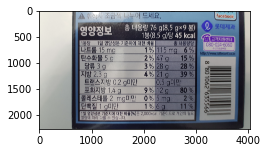

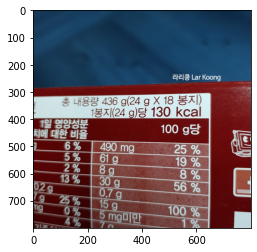

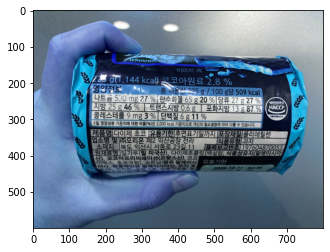

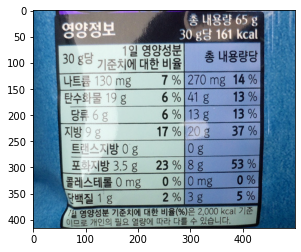

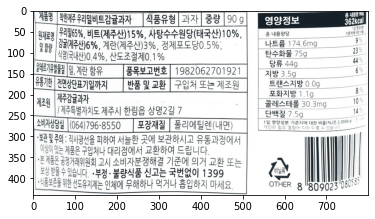

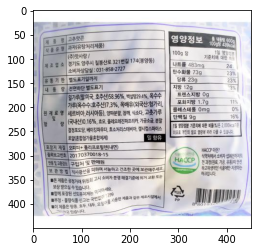

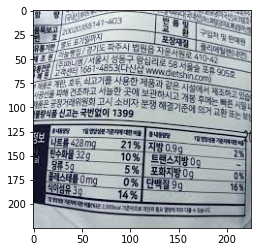

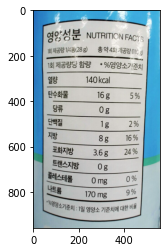

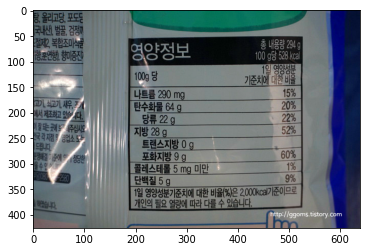

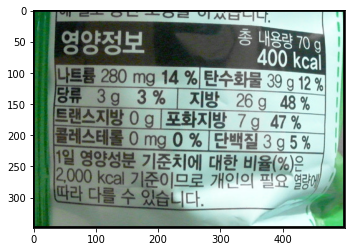

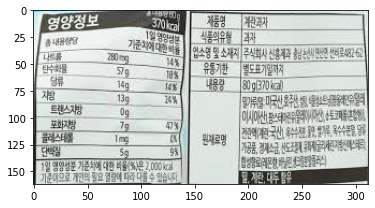

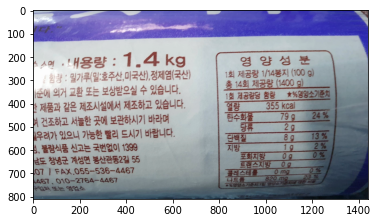

In [5]:
rows = 4
cols = 3
fig = plt.figure(figsize=(20,10))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

- 구글에서 영양 성분 표가 있는 과자 봉지 사진 12장을 가져왔다.

## 2. keras-ocr

In [6]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

- 시각화 하기

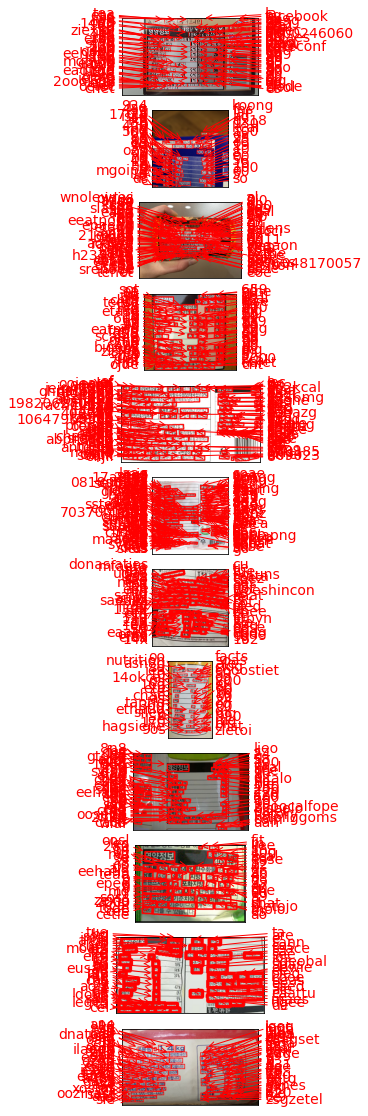

In [8]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

## 2. Tesseract

In [54]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

- 결과 출력

In [55]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [57]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/fold/kor'
    
    
tesseract_result_path = []
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir)
    tesseract_result_path.extend(image_path_list)

recognize_images(tesseract_result_path)

SystemError: tile cannot extend outside image

## 3. 테스트 결과 시각화

- 두 모델 비교 함수

In [58]:
def ocr_model_comparison(img_idx):
    print('Original image:')
    img = cv2.imread(file_path[img_idx], cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.show()


    print('Tesseract result:\n')
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/fold/kor/'+str(img_idx)
    cropped_image_path = crop_word_regions(file_path[img_idx], work_dir)
    recognize_images(cropped_image_path)
        
    print('keras-ocr result:\n')
    keras_ocr.tools.drawAnnotations(image=images[img_idx], predictions=prediction_groups[img_idx][0])

- 임의로 3개의 이미지만 비교해보기

Original image:


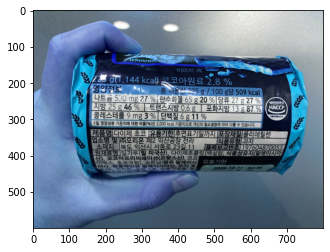

Tesseract result:


_ 1”

요 | 포화지방 13 8 87 :이(25594 ^

가


아오어0

시방

나

요

46

6

"

드딘

^

주,

브『

)6 이

노고

ㅣ

부도

호

콜레스테롤 9 ㅠㅇ3 %

9

078

궁


단백질 6

811

%

'

버

명

양

심문

|

6 ^

|

에

내한

|

뮬

%)은

도

2000

(그

/ |

준이

ㄴ

내

구

고

자

~

내

들

0"

캐

-

7976

남구

승

주

[4

(

/

”활, 탤업소명 및 순오리온 제2 익산공장



겨

Done
keras-ocr result:



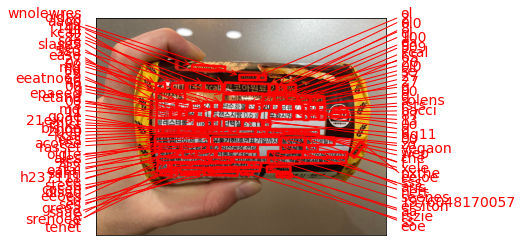

In [59]:
ocr_model_comparison(2)

Original image:


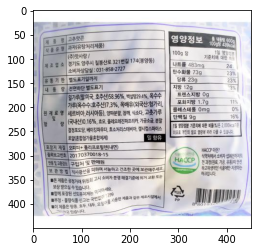

Tesseract result:



양주시

칠

봉스

(산5


34

1번


174

속

양동

소서

|자상담실: 031




:

031

1 년 | 보이 거여 은 쓰2 르뽀


'

밀

바

호.

주시


158.96%6



^

42비아러사동.

8

식소다,


루

|

국니

내


110.16%,

효모

을

트러 5

12

래

빼

가

뽀

:리

「

^

/


준닐

셜정오


베이킹파우더

호소처리스터비이,

28486

8 | 적사강 =

패


내

1





곳에 보관해주세으.

내

=




| 윈논

은

그시

81


-

해절 7

준하

본

"1

거고

고

닷

<

로

&상)

발도

는

실:

수

。 있습니다

|)"

또

0 함께 포장된 선도육지 시

자


8도육지저




해

식울


신고는 죽도



00


1

2


제주


뱅

버



을 |

결

방품은 >


즈ㅜ

다드

아스

~ |

9

| | 600포흔94427 80 00000 00200 |

| | 6이저은당응 호두 대두 오진 후 0


(다 012"

석각저에버 소비사

써

| 과정|원료 =

'

간신

자고외생적이 식풍예가 사정아은

마크업니나

두


1000

고

- 재 0

~

이 2220”

ㅣ

Done
keras-ocr result:



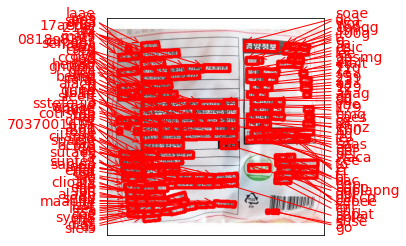

In [60]:
ocr_model_comparison(5)

Original image:


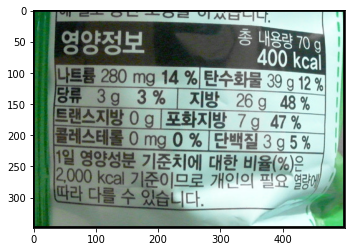

Tesseract result:

순치

10

|

대한

비율(?

국


9

-\


무로

개


( )

피아

204

개


Done
keras-ocr result:



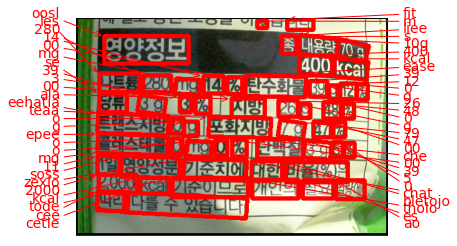

In [61]:
ocr_model_comparison(9)

Original image:


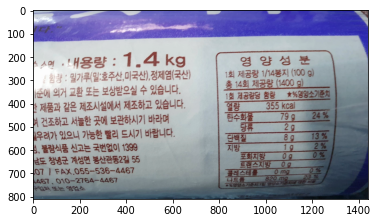

Tesseract result:

/4/7.

0

ㅅㅅ ㅅ


결 는

”

41

래



미국산],

0

|안

에

"|

비 /1

~

또는

도

상롱

반으슬

발이

있습니다.

1

제

과

괴

같은

세2

ㅅㅅ

|

설

에

제/

%

하고

있습니다.

”

건

수

하고

써

즐힌

:

끗에

도

과?

하시기

바라며

1

력7\

력

17

있으니

7\는한

빨리

드

/

)'

바랍니다.

이

불

랍〉

식물

신격

니고누

=

구몬

없

(

01

1394

6

”`

선도

ㆍ …

| 몽

츠쓰고

관동

3

3

1

55

0 뽀

-…  이시    놈

|

ㅣ

| 조회 43항04009. |


| 고 28 |

| 9 4

| 던렉질 0 0

| 202 , < 4


2

승

=


로

회

서군

호


130

코

|

100 이

"

1400) 6

Done
keras-ocr result:



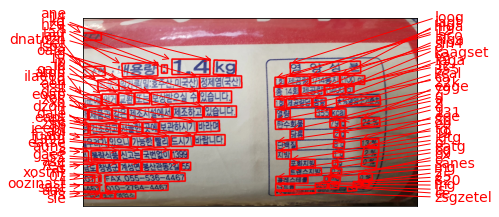

In [62]:
ocr_model_comparison(11)

## 4. 결과 분석

- Tesseract  
영양 정보 이외에도 여러 가지가 인식되었다. 긴 문장에 대해서 잘 인식한것같다.
- keras-ocr  
텍스트가 있는 위치를 잘 찾아낸다. 그치만 한글이 엉뚱하게 나오긴 해서 아쉽다.

## 회고

- 어려운점 :  tile cannot extend outside image 에러가 자꾸 떠서 힘들었다. 그치만 이미 학습이 된거같아서 아래를 실행시켰을때 문제는 없었다.
- 노력한점: 한글이 많이 적힌 사진이 무엇인지 생각해보았다.
- 궁금한점 : keras-ocr에서 한글도 인식시켜 보고 싶다는 생각이 들었다.
- 다짐: ocr에대해 관심이 없었는데 이번 기회에 잘 알게 되어서 우리 일상에 많이 쓰인다는 것을 알았다.